In [2]:
import os, sys, glob, shutil, subprocess, re, tqdm
print(os.getcwd())
%ls

/media/tug27224/6BE3F40755E45C2A
delete/              PROJ14094/  PROJ14096/  PROJ14098/  PROJ14100/  sizes*
FAH_analysis.ipynb*  PROJ14095/  PROJ14097/  PROJ14099/  projects/


In [8]:
# This script takes in an entire raw dataset from Folding@Home to process it for analysis
# by concatenating each clone and running periodic boundary correction.
# It requires that Gromacs be installed for use of trjconv and trjcat.
# Currently, the script may not work if runs contain different systems and therefore
# differing index files/groups.
# output from the script goes into an analysis directory containing one or both of
# traj_data / xvg_data. 
# If you can't figure something out, ask Matt (tug27224@temple.edu) for assistance.

# directory that contains raw data directories, e.g. ~/server2/data/SVR166219
# data_dir should contain ['PROJ%s'%project for project in projects]
# as well as projects/Gromacs/pXXXXX from ~/server2/projects for the index.ndx files.
data_dir = '.'

# project IDs to be processed. data_dir should contain 
# ['PROJ%s'%project for project in projects] as well as projects/Gromacs/pXXXXX for index.ndx
# projects are followed by the index groups used by trjconv.
# projects[i][1] denotes the group to be centered, and projects[i][2] denotes 
# the group for output, e.g. [14100,1,20], such that 1: Protein, 20: Protein_Ligand
projects = [[14094,14,14],
            [14095,15,15],
            [14096,15,15],
            [14097,15,15],
            [14098,0,0],
            [14099,0,0],
            [14100,0,0]]

# choose one or both of trajectories and xvg files to concatenate.
# warning: xvg files can get big..
trjcat = True
xvgcat = False
pbc_method = 'mol' # 'mol','whole','nojump'
verbose = False # set True if you encounter errors

# loop through each project, determining trjconv group indices and n_runs/clones
p= -1
for p in tqdm.tqdm_notebook(range(len(projects)),desc='Processing PROJ%d'%projects[p][0]):
    center_ndx = projects[p][1]
    output_ndx = projects[p][2]
    n_runs = len(glob.glob('%s/PROJ%d/RUN*' %(data_dir,projects[p][0])))
    n_clones = len(glob.glob('%s/PROJ%d/RUN0/CLONE*' %(data_dir,projects[p][0])))

    # assign tpr and ndx files for PBC correction and loop through each run,clone,gen
    r = -1
    for r in tqdm.tqdm_notebook(range(n_runs),desc='RUN%s'%r,leave=False):
        tpr_file = '%s/PROJ%d/RUN%d/CLONE0/frame0.tpr' %(data_dir,projects[p][0],r)
        ndx_file = '%s/projects/Gromacs/p%d/RUN%d/xtc.ndx' %(data_dir,projects[p][0],r)
        c = -1
        for c in tqdm.tqdm_notebook(range(n_clones),desc='CLONE%d'%c,leave=False):
            gen_dirs = []
            n_gens = len(glob.glob('%s/PROJ%d/RUN%d/CLONE%d/results[0-9]*' %(data_dir,projects[p][0],r,c)))
            for g in range(n_gens):
                gen_dirs.append('%s/PROJ%d/RUN%d/CLONE%d/results%d' %(data_dir,projects[p][0],r,c,g))
            
            # ignore empty clones
            if not gen_dirs:
                pass
            
            # concatenate trajectories and correct periodic boundary conditions
            # uses gmx trjconv -f .xtc -s .tpr -n .ndx -pbc pbc_method -center -o .xtc
            if trjcat:       
                # create output directory
                if not os.path.isdir('%s/analysis/PROJ%d/traj_data'%(data_dir,projects[p][0])):
                    os.makedirs('%s/analysis/PROJ%d/traj_data'%(data_dir,projects[p][0]))
                    
                for g in range(len(gen_dirs)):                        
                    # get input/output paths for each WU
                    traj_file = gen_dirs[g] + '/traj_comp.xtc'
                    traj_dest = '%s/analysis/PROJ%d/traj_data/P%d_R%d_C%d_F%s.xtc' %(data_dir,projects[p][0],
                                                                                     projects[p][0],r,c,
                                                                                     str(g).zfill(3))
                    try: # copy each gen to output directory
                        shutil.copy2(traj_file, traj_dest)
                    except Exception as e:
                        if verbose:
                            print(e, 'Unable to copy trajectory: %s'%traj_file)
                        continue
                
                # denotes bash regex for all input trajectories and the concatenated output
                concat_in = '%s/analysis/PROJ%d/traj_data/P%d_R%d_C%d_F*' %(data_dir,projects[p][0],projects[p][0],r,c)
                concat_out = '%s/analysis/PROJ%d/traj_data/xP%d_R%d_C%d.xtc' %(data_dir,projects[p][0],projects[p][0],r,c)
                concat_cmd = 'gmx trjcat -f %s -o %s' %(concat_in,concat_out)
                
                try: # concatenate the frames for each run of each clone
                    subprocess.check_output(concat_cmd, stderr=subprocess.STDOUT, shell=True)
                except Exception as e:
                    if verbose:
                        print(e, 'Unable to concatenate %s'%concat_in)
                    continue
                
                # remove the pre-concatenated trajectories
                for file in glob.glob(concat_in):
                    os.remove(file)
                
                # denote input and output files for PBC correction step
                pbc_in = concat_out
                pbc_out = re.sub('xP','P',pbc_in)

                pbc_cmd = 'echo -e "%d\n%d\n" | gmx trjconv -f %s -pbc %s'%(center_ndx, output_ndx, pbc_in, pbc_method) +\
                   '-f %s -pbc %s'center -n %s -s %s -o %s' %(ndx_file, tpr_file, pbc_out)

                try: # run PBC correction
                    subprocess.check_output(pbc_cmd, stderr=subprocess.STDOUT, shell=True)
                except Exception as e:
                    if verbose:
                        print(e, 'Unable to run PBC correction for %s. ' +\
                          'Check ndx/tpr files and groups.'%pbc_in)
                    continue
                
                # remove concatenated, pre-PBC trajectory
                os.remove(pbc_in)
            
            # concatenate xvg files per clone by appending all but top 41 lines
            # which normally contain comments.
            if xvgcat:
                if not os.path.isdir('%s/analysis/xvg_data'%data_dir):
                    os.makedirs('%s/analysis/xvg_data'%data_dir)
                
                for g in range(n_gens):
                    xvg_file = gens[g] + '/dhdl.xvg'
                    xvg_dest = '%s/analysis/PROJ%d/xvg_data/P%d_R%d_C%d.xvg' %(data_dir,projects[p][0],r,c)
                    if g == 0:
                        xvg_concat_cmd = 'cp %s %s' %(xvg_file,xvg_dest)
                    else:
                        xvg_concat_cmd = 'tail -n +41 %s >> %s' %(xvg_file,xvg_dest)
                    
                    try:
                        subprocess.check_output(xvg_concat_cmd, stderr=subprocess.STDOUT, shell=True)
                    except Exception as e:
                        if verbose:
                            print('Unable to concatenate xvg files for %s'%xvg_dest)
                        break
                
                

TypeError: not all arguments converted during string formatting

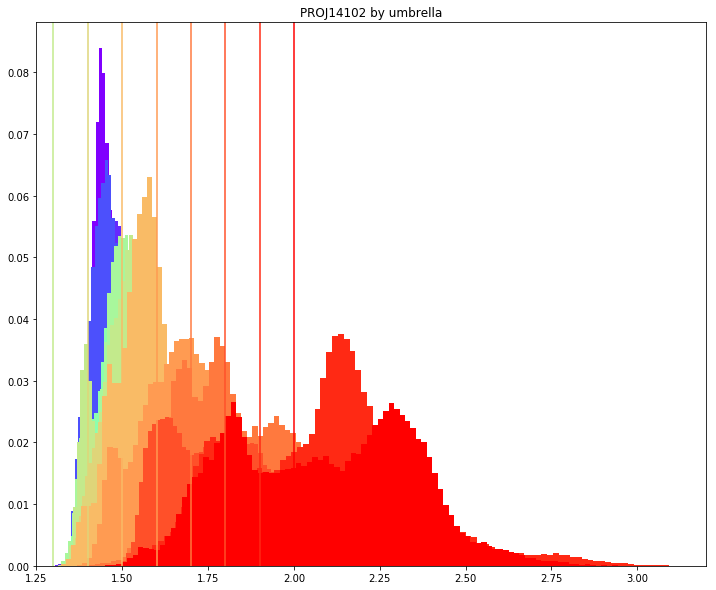

In [20]:
## 14102 BY HARMONIC RESTRAINT
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14102
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 20
colors = cm.rainbow(np.linspace(0, 1, runs))
plt.figure(figsize=(12,10))
for i in range(runs): # 20 runs in this project
    restraint = i/10. + 0.1
    feature_files,avg_distances = [],[]
    for j in all_feature_files:
        if '_R%d_'%i in j:
            feature_files.append(j)

    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for k in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][k]))
            
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    plt.hist(avg_distances,bins=100,color=colors[i],weights=weights)
    plt.axvline(restraint, color=colors[i])
    plt.xlim(1.25,3.2)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by umbrella'%project)
plt.show()


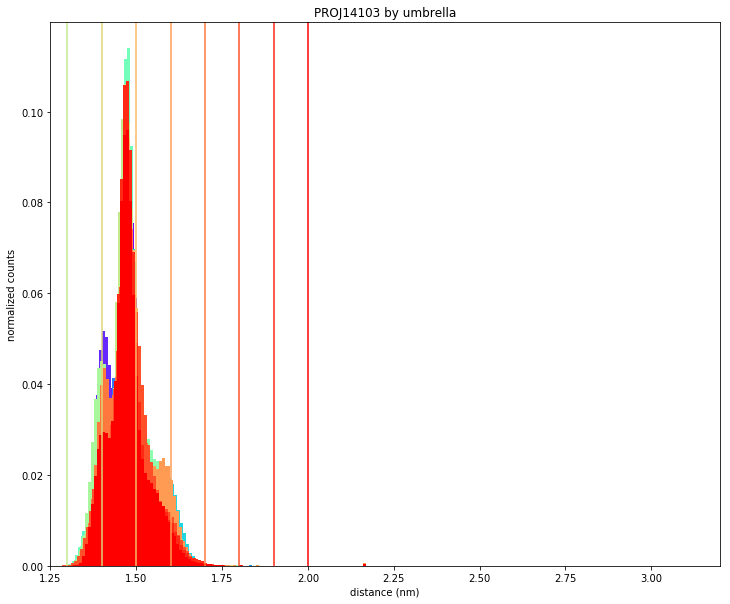

In [30]:
## 14102 BY HARMONIC RESTRAINT
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14103
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 20
colors = cm.rainbow(np.linspace(0, 1, runs))
plt.figure(figsize=(12,10))
for i in range(runs): # 20 runs in this project
    restraint = i/10. + 0.1
    feature_files,avg_distances = [],[]
    for j in all_feature_files:
        if '_R%d_'%i in j:
            feature_files.append(j)

    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for k in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][k]))
            
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    plt.hist(avg_distances,bins=100,color=colors[i],weights=weights)
    plt.axvline(restraint, color=colors[i])
    plt.xlim(1.25,3.2)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by umbrella'%project)
plt.show()


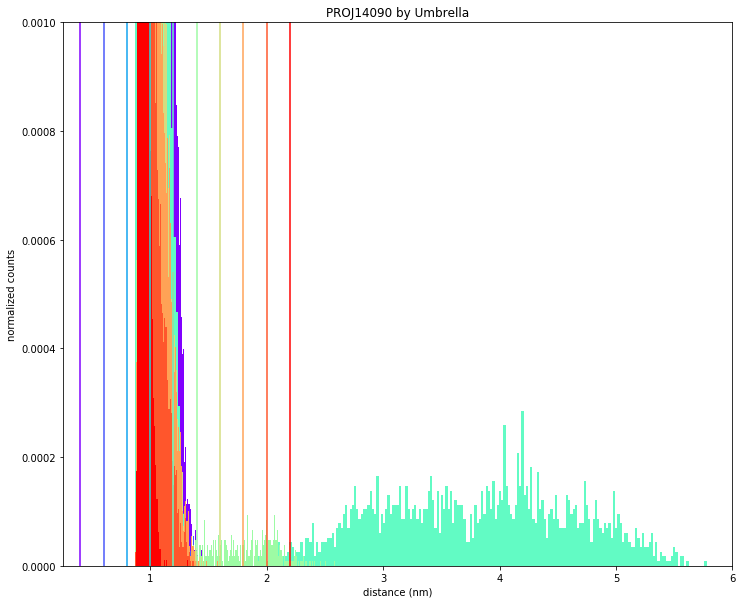

In [25]:
## 14090 BY HARMONIC RESTRAINT
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14090
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 200
n_umbrellas = 10
colors = cm.rainbow(np.linspace(0, 1, n_umbrellas))
plt.figure(figsize=(12,10))
for k in range(n_umbrellas): # 10 different restraints
    restraint = k%n_umbrellas * 0.2 + 0.4
    feature_files,avg_distances = [],[]
    for i in range(runs): # 200 runs in this project
        for j in all_feature_files:
            if i%n_umbrellas == k:
                if '_R%d_'%i in j:
                    feature_files.append(j)
                    
    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for l in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][l]))
    
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    n, bins, patches = plt.hist(avg_distances,bins=256,color=colors[k],weights=weights)
    plt.axvline(restraint, color=colors[k])
    plt.xlim(0.25,6.0)
    plt.ylim(0,0.001)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by Umbrella'%project)
plt.show()


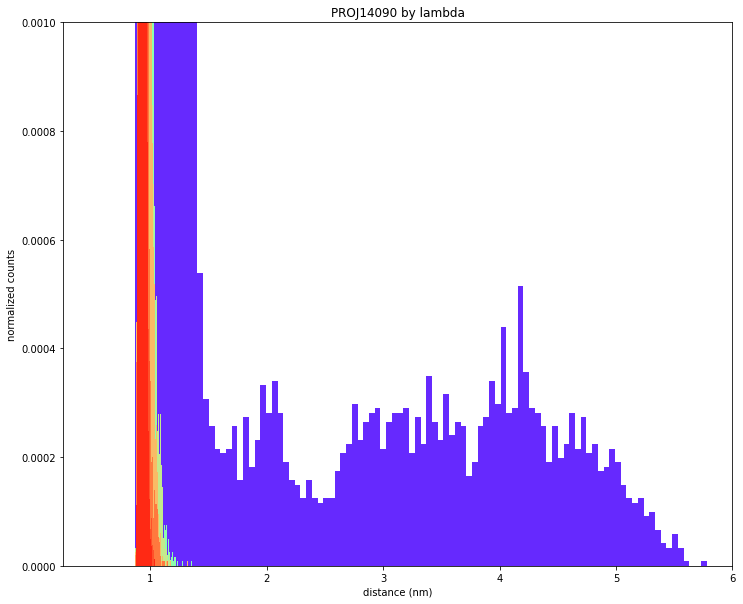

In [26]:
## 14090 BY FEP_LAMBDA
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14090
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 200
n_fep = 20
colors = cm.rainbow(np.linspace(0, 1, n_fep))
plt.figure(figsize=(12,10))
for k in range(n_fep): # 20 fep lambdas
    fep_lambda = k
    feature_files,avg_distances = [],[]
    for i in range(runs): # 200 runs in this project
        for j in all_feature_files:
            if int(i/10) == k:
                if '_R%d_'%i in j:
                    feature_files.append(j)

    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for l in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][l]))
            
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    n, bins,patches = plt.hist(avg_distances,bins=100,color=colors[k],weights=weights)
    plt.xlim(0.25,6)
    plt.ylim(0,0.001)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by lambda'%project)
plt.show()


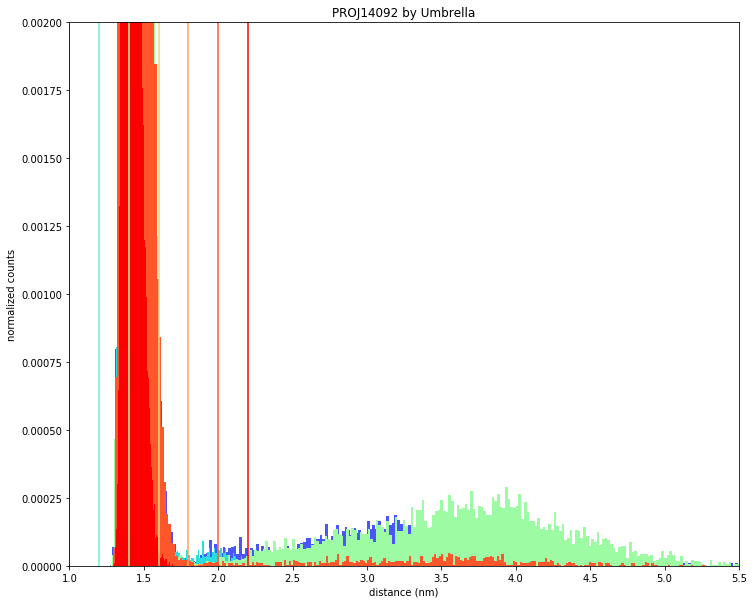

In [19]:
## 14092 BY HARMONIC RESTRAINT
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14092
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 200
n_umbrellas = 10
colors = cm.rainbow(np.linspace(0, 1, n_umbrellas))
plt.figure(figsize=(12,10))
for k in range(n_umbrellas): # 10 different restraints
    restraint = k%n_umbrellas * 0.2 + 0.4
    feature_files,avg_distances = [],[]
    for i in range(runs): # 200 runs in this project
        for j in all_feature_files:
            if i%n_umbrellas == k:
                if '_R%d_'%i in j:
                    feature_files.append(j)
                    
    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for l in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][l]))
    
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    n, bins, patches = plt.hist(avg_distances,bins=256,color=colors[k],weights=weights)
    plt.axvline(restraint, color=colors[k])
    plt.xlim(1.0,5.5)
    plt.ylim(0,0.002)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by Umbrella'%project)
plt.show()


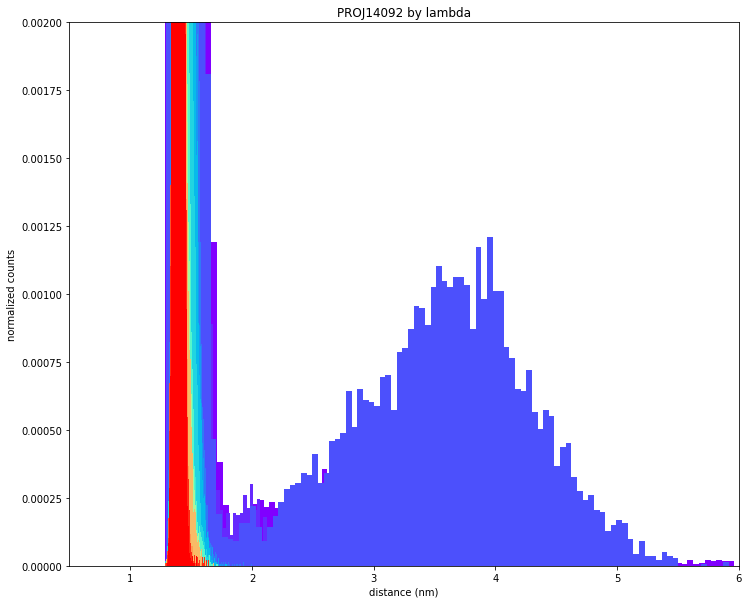

In [23]:
## 14092 BY FEP_LAMBDA
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14092
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 200
n_fep = 20
colors = cm.rainbow(np.linspace(0, 1, n_fep))
plt.figure(figsize=(12,10))
for k in range(n_fep): # 20 fep lambdas
    fep_lambda = k
    feature_files,avg_distances = [],[]
    for i in range(runs): # 200 runs in this project
        for j in all_feature_files:
            if int(i/10) == k:
                if '_R%d_'%i in j:
                    feature_files.append(j)

    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for l in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][l]))
            
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    n, bins,patches = plt.hist(avg_distances,bins=100,color=colors[k],weights=weights)
    plt.xlim(0.5,6)
    plt.ylim(0,0.002)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by lambda'%project)
plt.show()


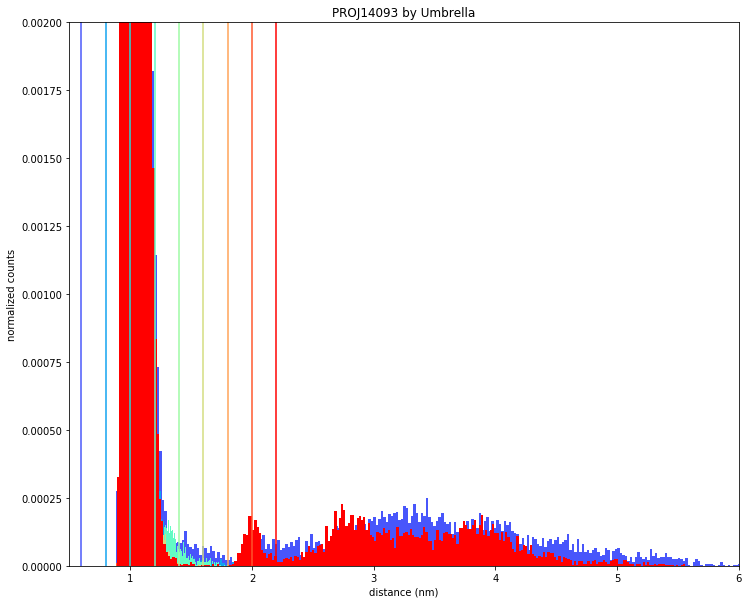

In [28]:
## 14093 BY HARMONIC RESTRAINT
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14093
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 200
n_umbrellas = 10
colors = cm.rainbow(np.linspace(0, 1, n_umbrellas))
plt.figure(figsize=(12,10))
for k in range(n_umbrellas): # 10 different restraints
    restraint = k%n_umbrellas * 0.2 + 0.4
    feature_files,avg_distances = [],[]
    for i in range(runs): # 200 runs in this project
        for j in all_feature_files:
            if i%n_umbrellas == k:
                if '_R%d_'%i in j:
                    feature_files.append(j)
                    
    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for l in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][l]))
    
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    n, bins, patches = plt.hist(avg_distances,bins=256,color=colors[k],weights=weights)
    plt.axvline(restraint, color=colors[k])
    plt.xlim(0.5,6.0)
    plt.ylim(0,0.002)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by Umbrella'%project)
plt.show()


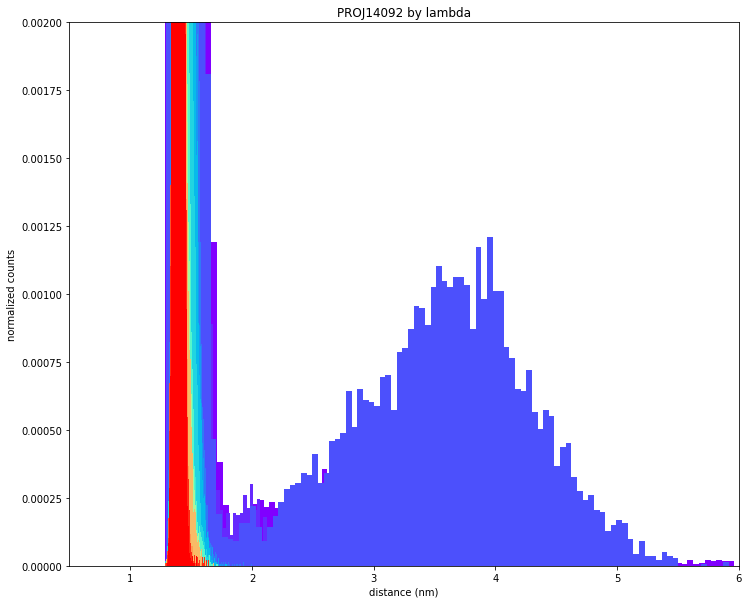

In [29]:
## 14092 BY FEP_LAMBDA
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

prefix = '/media/matt/methuselah1'
project = 14092
maxs,stds,mins = [],[],[]
atom_selections = ['C']
residues = ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN','B1A','B2A','B1B','B2B','B1C','B2C','B1D','B2D','B1E','B2E']
all_feature_files = sorted(glob.glob('%s/TRAJECTORIES/features/p%s/*npy'%(prefix,project)))
runs = 200
n_fep = 20
colors = cm.rainbow(np.linspace(0, 1, n_fep))
plt.figure(figsize=(12,10))
for k in range(n_fep): # 20 fep lambdas
    fep_lambda = k
    feature_files,avg_distances = [],[]
    for i in range(runs): # 200 runs in this project
        for j in all_feature_files:
            if int(i/10) == k:
                if '_R%d_'%i in j:
                    feature_files.append(j)

    features = [np.load(x) for x in feature_files]
    for j in range(len(features)): # for each clone
        for l in range(len(features[j])): # for each frame
            avg_distances.append(np.average(features[j][l]))
            
    weights = np.ones_like(avg_distances)/float(len(avg_distances))
    n, bins,patches = plt.hist(avg_distances,bins=100,color=colors[k],weights=weights)
    plt.xlim(0.5,6)
    plt.ylim(0,0.002)
    plt.xlabel('distance (nm)')
    plt.ylabel('normalized counts')
    plt.title('PROJ%d by lambda'%project)
plt.show()


In [27]:
# recalculate features as single distance COM ligand to pocket

In [41]:
import datetime
now = datetime.datetime.now()
if str(now).split()[1][0:8] == '15:55:00':
    

15:51:29.
